<a href="https://colab.research.google.com/github/wilberquito/Thesis/blob/main/Code/nn/notebooks/resnet18/ResNet18_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet18, V1

In [1]:
import requests
from pathlib import Path
import pandas as pd
import seaborn as sns
from zipfile import ZipFile

try:
    import google.colab
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
In colab: True


In [2]:
def pull_code():
  print("Unzipping the code from google drive")
  !rm -rf modular/
  !unzip ./drive/MyDrive/wilberquito_thesis/modular.zip -d . >/dev/null 2>&1

if IN_COLAB:
    pull_code() 

Unzipping the code from google drive


In [11]:
def pull_data():
  answer = input("You sure? Y/n\n")
  if answer != "Y":
    return

  print("Unzipping the data from google drive")
  !rm -rf data.etl/
  !unzip ./drive/MyDrive/wilberquito_thesis/data.zip -d . >/dev/null 2>&1

if IN_COLAB:
    pull_data() 

You sure? Y/n
Y
Unzipping the data from google drive


In [5]:
!nvidia-smi

Mon May 22 07:44:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Scheduler

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25
STEP_SIZE = 15
GAMMA = 0.2

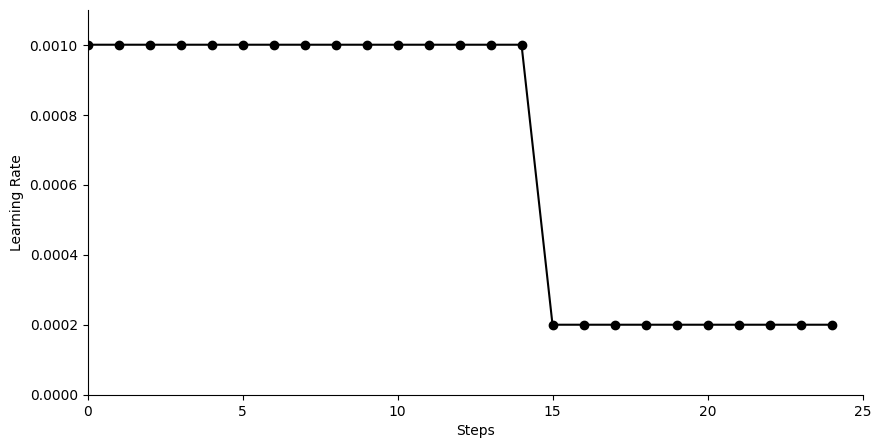

In [ ]:
import torch
import torch.optim.lr_scheduler as lr_scheduler # Import your choice of scheduler here

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Set model and optimizer
model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Define your scheduler here as described above
# ...
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# Get learning rates as each training step
learning_rates = []

for i in range(EPOCHS):
    optimizer.step()
    learning_rates.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

# Visualize learinig rate scheduler
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(range(1, EPOCHS + 1), 
        learning_rates,
        marker='o', 
        color='black')
ax.set_xlim([1, EPOCHS])
ax.set_ylim([0, LEARNING_RATE + 0.0001])
ax.set_xlabel('Steps')
ax.set_ylabel('Learning Rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Writter

In [7]:
import modular.utility as m_utility

writter = m_utility.model_writter('resnet18_v1')

## Fine Tunning

In [8]:
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.models import (ResNet18_Weights)
from torch.utils.data import DataLoader
import torch
import torchvision as tv
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.engine as engine

# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, test_df, mapping = m_dataset.get_df(data_dir, data_folder)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_ft = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(mapping))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)


# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }

# Train and validate dataset & dataloader
train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.15)


train_transform = tv.transforms.Compose([
    tv.transforms.Resize(256),
    tv.transforms.CenterCrop(224),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

validate_transform = tv.transforms.Compose([
    tv.transforms.Resize(256),
    tv.transforms.CenterCrop(224),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = m_dataset.MelanomaDataset(train_df,
                                          mode='train',
                                          transform=train_transform,
                                          idx_to_class=idx_to_class)                                                       
validate_dataset = m_dataset.MelanomaDataset(validate_df,
                                             mode='validate',
                                             transform=validate_transform,
                                             idx_to_class=idx_to_class)                                                       

batch_size = 512                                             

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

# Test dataset and dataloader
test_dataset = m_dataset.MelanomaDataset(test_df,
                                         mode='test',
                                         idx_to_class=idx_to_class)                                                       
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Dataloaders
dataloaders = {
    'train': train_dataloader,
    'val': validate_dataloader,
}

datasets_size = {
    'train': len(train_dataset),
    'val': len(validate_dataset),
}

about_data = {
    'dataloaders': dataloaders,
    'datasets': {
        'size': datasets_size
    }
}

mel_idx = 6 # Check data exploration notebook

model_ft, stats = engine.train_model(model_ft, 
                                     mel_idx,
                                     about_data,
                                     device,
                                     criterion, 
                                     optimizer, 
                                     scheduler,
                                     num_epochs=25,
                                     writter=writter,
                                     val_times=4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 333MB/s]


Epoch 1/25
----------
Train Auc: 0.8131 	|	Train Loss: 1.1670 	|	Train Acc: 0.6102
Val Auc: 0.7759 	|	Val Loss: 0.9252 	|	Val Acc: 0.6821
=> Saving a new checkpoint
Epoch 2/25
----------
Train Auc: 0.8237 	|	Train Loss: 0.8894 	|	Train Acc: 0.6892
Val Auc: 0.8216 	|	Val Loss: 0.8486 	|	Val Acc: 0.7034
=> Saving a new checkpoint
Epoch 3/25
----------
Train Auc: 0.8475 	|	Train Loss: 0.8183 	|	Train Acc: 0.7105
Val Auc: 0.8294 	|	Val Loss: 0.8026 	|	Val Acc: 0.7151
=> Saving a new checkpoint
Epoch 4/25
----------
Train Auc: 0.8750 	|	Train Loss: 0.7698 	|	Train Acc: 0.7264
Val Auc: 0.8205 	|	Val Loss: 0.7683 	|	Val Acc: 0.7264
Epoch 5/25
----------
Train Auc: 0.8740 	|	Train Loss: 0.7315 	|	Train Acc: 0.7380
Val Auc: 0.8328 	|	Val Loss: 0.7483 	|	Val Acc: 0.7281
=> Saving a new checkpoint
Epoch 6/25
----------
Train Auc: 0.9043 	|	Train Loss: 0.6955 	|	Train Acc: 0.7512
Val Auc: 0.8305 	|	Val Loss: 0.7256 	|	Val Acc: 0.7362
Epoch 7/25
----------
Train Auc: 0.9355 	|	Train Loss: 0.6653 	|

## Train performance

In [1]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [3]:
def pull_models():
  answer = input("You sure? Y/n\n")
  if answer != "Y":
    return

  print("Loading models from google drive")
  !rm -rf models/
  !cp -r ./drive/MyDrive/wilberquito_thesis/models . >/dev/null 2>&1

if IN_COLAB:
    pull_models() 

You sure? Y/n
Y
Loading models from google drive


In [5]:
import torch
import modular.utility as m_utility
import modular.models as m_models


model_path = 'models/resnet18/resnet18_v1.pth.tar'
checkpoint = torch.load(model_path)

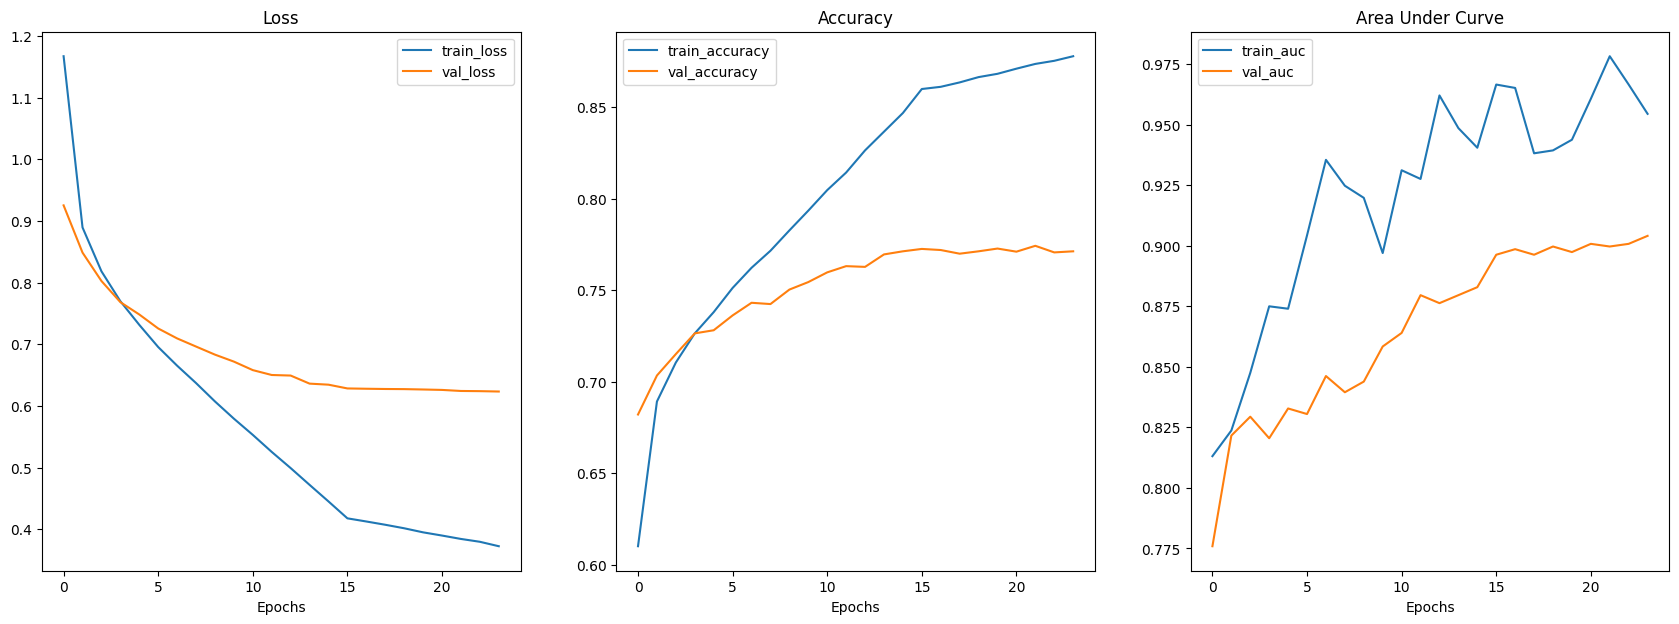

In [6]:
m_utility.plot_curves(checkpoint['stats'])

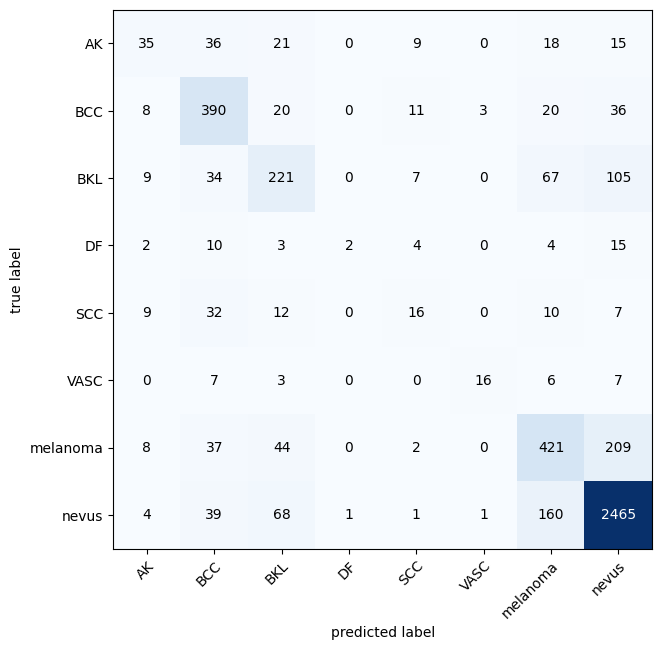

In [7]:
import torch
import torchvision as tv
import torch.nn as nn
import modular.dataset as m_dataset
import modular.utility as m_utility
import modular.models as m_models
from torch.utils.data import DataLoader
from torchvision.models import (ResNet18_Weights)
import torchvision.models as models


# Set seed
m_utility.set_seed(42)

# Build the dataframes
data_dir = 'data.etl'
data_folder = '512'
train_df, _, mapping = m_dataset.get_df(data_dir, data_folder)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 512                                             

# Mapping from id to classname
idx_to_class = { k : classname for classname, k in mapping.items() }

# Train and validate dataset & dataloader
train_df, validate_df = m_dataset.train_validate_split(train_df,
                                                       random_state=42,
                                                       validate_size=0.15)


validate_transform = tv.transforms.Compose([
    tv.transforms.Resize(256),
    tv.transforms.CenterCrop(224),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) 

validate_dataset = m_dataset.MelanomaDataset(validate_df,
                                             mode='validate',
                                             transform=validate_transform,
                                             idx_to_class=idx_to_class) 
validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
class_names = [name for k,name in validate_dataset.idx_to_class.items()]

model_ft = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(mapping))

model_state_dict = checkpoint['model_state_dict']
model_ft.load_state_dict(model_state_dict)
model_ft = model_ft.to(device)

m_utility.plot_confusion_matrix(model_ft,
                                validate_dataloader,
                                class_names,
                                device)